# ライブラリのImportと物理定数定義

In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

c = 2.99792458e8 # 光速[m/s]
eps0 = 8.854187817e-12
mu0 = 1.2566370614e-6

# ユーザー定数定義

In [2]:
dx = 0.003 # x方向空間差分間隔[m]

nx = 50 # x方向計算点数
ny = 50 # y方向計算点数
nz = 50 # z方向計算点数

dt = 0.99/(c * np.sqrt((1.0/dx ** 2 + 1.0/dx ** 2 + 1.0/dx ** 2))) # 時間差分間隔[s] c.f.Courantの安定条件
nt = 2 ** 15 # 計算ステップ数

# 解析空間のSetup

In [3]:
# 電気定数初期化と更新係数の計算
eps = cp.full((nx, ny, nz), eps0)
mu = cp.full((nx, ny, nz), mu0)
sigma = cp.full((nx, ny, nz), 0.0)
sigmam = cp.full((nx, ny, nz), 0.0)

# PML用のパラメータ
M = 3     # 吸収境界の導電率の上昇曲線の次数(2 - 3次が一般的)
R = 1e-6  # 境界面において実現したい反射係数
pmlN = 16 # PMLの層数、大きいほど計算コストが増えるが、反射率低減可

for ln in range(pmlN):
    sigma_value = ((pmlN - ln)/pmlN) ** M * ((M + 1) * (-np.log(R))/(2 * pmlN * dx * 120 * np.pi)) # PML吸収境界のsigma計算
    
    sigma[ln : ln + 1, :, :] = sigma_value
    sigma[:, ln : ln + 1, :] = sigma_value
    sigma[:, :, ln : ln + 1] = sigma_value

    sigma[-(ln + 1) : -ln, :, :] = sigma_value
    sigma[:, -(ln + 1) : -ln, :] = sigma_value
    sigma[:, :, -(ln + 1) : -ln] = sigma_value
    
    sigmam[ln : ln + 1, :, :] = mu0/eps0 * sigma_value
    sigmam[:, ln : ln + 1, :] = mu0/eps0 * sigma_value
    sigmam[:, :, ln : ln + 1] = mu0/eps0 * sigma_value

    sigmam[-(ln + 1) : -ln, :, :] = mu0/eps0 * sigma_value
    sigmam[:, -(ln + 1) : -ln, :] = mu0/eps0 * sigma_value
    sigmam[:, :, -(ln + 1) : -ln] = mu0/eps0 * sigma_value
    
    
ch = (2.0 * mu - sigmam * dt)/(2.0 * mu + sigmam * dt) # 式(12) - (14)の右辺第一項係数
dh = 2.0 * dt /((2.0 * mu * dx) + (sigmam * dt * dx)) # 式(12) - (14)の右辺第二項係数

ce = (2.0 * eps - sigma * dt)/(2.0 * eps + sigma * dt) # 式(12) - (14)の右辺第一項係数
de = 2.0 * dt /((2.0 * eps * dx) + (sigma * dt * dx)) # 式(12) - (14)の右辺第二項係数

# 電磁界初期化
t = 0.0

E_x = cp.zeros(shape=(nx, ny, nz))
E_y = cp.zeros(shape=(nx, ny, nz))
E_z = cp.zeros(shape=(nx, ny, nz))
H_x = cp.zeros(shape=(nx, ny, nz))
H_y = cp.zeros(shape=(nx, ny, nz))
H_z = cp.zeros(shape=(nx, ny, nz))

tlist = np.zeros(nt)
itime = np.zeros(nt)
vtime = np.zeros(nt)

# 解析実行

In [4]:
for _ in tqdm(range(nt)):
        
    # 電界のz成分を励振
    Vin = -((t-100*dt)/dt) * cp.exp(-((t-100*dt)/dt)**2)
    E_z[nx//2, ny//2, nz//2] = -Vin/dx
    t += dt/2
    
    # 電界各成分計算
    E_x = ce * E_x + de * ((H_z - cp.roll(H_z, shift=1, axis=1))\
                          -(H_y - cp.roll(H_y, shift=1, axis=2)))

    E_y = ce * E_y + de * ((H_x - cp.roll(H_x, shift=1, axis=2))\
                         - (H_z - cp.roll(H_z, shift=1, axis=0)))

    E_z = ce * E_z + de * ((H_y - cp.roll(H_y, shift=1, axis=0))\
                         - (H_x - cp.roll(H_x, shift=1, axis=1)))
            
    E_z[nx//2, ny//2, nz//2 - 10: nz//2 + 10] = 0
    Eamp = cp.sqrt(E_x**2 + E_y**2 + E_z**2)
    
    # 電界のz成分を励振
    Vin = -((t-100*dt)/dt) * cp.exp(-((t-100*dt)/dt)**2)
    E_z[nx//2, ny//2, nz//2] = -Vin/dx
    t += dt/2
    
    # 磁界各成分計算
    H_x = ch * H_x + dh * ((E_z - cp.roll(E_z, shift=-1, axis=1))\
                         - (E_y - cp.roll(E_y, shift=-1, axis=2)))

    H_y = ch * H_y + dh *  ((E_x - cp.roll(E_x, shift=-1, axis=2))\
                          - (E_z - cp.roll(E_z, shift=-1, axis=0)))

    H_z = ch * H_z + dh *  ((E_y - cp.roll(E_y, shift=-1, axis=0))\
                          - (E_x - cp.roll(E_x, shift=-1, axis=1)))
    
    if _ % 2**6 == 0:
        npEamp = cp.asnumpy(Eamp)
        plt.imshow(npEamp[:, :, nz//2], vmin=0, vmax=1.0, cmap="Reds")
        plt.colorbar()
        plt.savefig("output/" + str(_).zfill(8) + ".png")
        plt.close('all')
    
    Iin = dx * (H_x[nx//2, ny//2 - 1, nz//2] - H_x[nx//2, ny//2, nz//2])\
        + dx * (H_y[nx//2, ny//2, nz//2] - H_y[nx//2 - 1, ny//2, nz//2])
    
    tlist[_] = t
    itime[_] = Iin
    vtime[_] = Vin

100%|███████████████████████████████████| 32768/32768 [03:41<00:00, 148.12it/s]


# 解析結果可視化

0.0053356606417986905 39364.88110485723 -47485.892487018464
0.010671321283597381 17916.383201832057 -34697.47147389228
0.016006981925396072 10130.414865548208 -26629.00040482813
0.021342642567194762 6462.002049717949 -21360.82932798486
0.026678303208993455 4478.8059856947275 -17737.454804654808
0.032013963850792145 3295.869438158339 -15126.063473478904
0.037349624492590834 2535.9544944987183 -13167.730216062162
0.042685285134389524 2019.1008277651297 -11650.207091081467
0.04802094577618822 1651.4384029719145 -10442.230911605697
0.05335660641798691 1380.327804817437 -9459.103706370523
0.0586922670597856 1174.449586765438 -8644.057762138149
0.06402792770158429 1014.2354540224128 -7957.759222190324
0.06936358834338298 886.9504056157917 -7372.155752069586
0.07469924898518167 784.0168727094461 -6866.733121234056
0.08003490962698036 699.4859736252072 -6426.158583478949
0.08537057026877905 629.1266975800878 -6038.75112319089
0.09070623091057775 569.8631788817885 -5695.460825929202
0.096041891

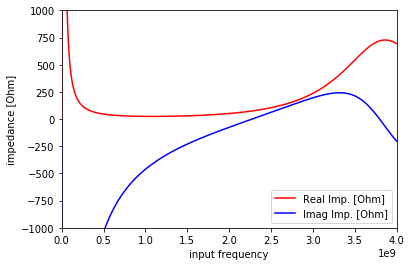

In [5]:
flist = np.linspace(0, 1/dt, nt)

start = 0
end = 4e9

ifreq = np.fft.fft(itime)
vfreq = np.fft.fft(vtime)
zfreq = vfreq/ifreq

fig = plt.figure()
plt.plot(flist, np.real(zfreq), color="red", label="Real Imp. [Ohm]")
plt.plot(flist, np.imag(zfreq), color="blue", label="Imag Imp. [Ohm]")
plt.ylim(-1000, 1000)
plt.xlim(start, end)
plt.ylabel("impedance [Ohm]")
plt.xlabel("input frequency")
plt.legend()
plt.savefig("dipole_imp.png")

for f, zre, zim in zip(flist[(start < flist) & (flist < end)], np.real(zfreq[(start < flist) & (flist < end)]), np.imag(zfreq[(start < flist) & (flist < end)])):
    print(f/1e9, zre, zim)

0.0053356606417986905 0.9989658438361843
0.010671321283597381 0.9988257781970189
0.016006981925396072 0.998752777024816
0.021342642567194762 0.998703367096466
0.026678303208993455 0.9986626569421623
0.032013963850792145 0.9986257346410385
0.037349624492590834 0.9985907401750802
0.042685285134389524 0.9985568313489338
0.04802094577618822 0.9985235562921262
0.05335660641798691 0.998490643529727
0.0586922670597856 0.9984579230168643
0.06402792770158429 0.9984252903950515
0.06936358834338298 0.9983926867093587
0.07469924898518167 0.9983600846618883
0.08003490962698036 0.9983274784490921
0.08537057026877905 0.9982948760851181
0.09070623091057775 0.9982622936681833
0.09604189155237644 0.9982297512100371
0.10137755219417513 0.9981972697130959
0.10671321283597382 0.9981648692180634
0.11204887347777251 0.9981325675896418
0.1173845341195712 0.998100379843647
0.12272019476136989 0.9980683178624481
0.12805585540316858 0.9980363903753854
0.13339151604496727 0.9980046031127761
0.13872717668676596 0.

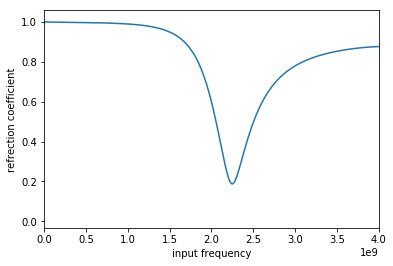

In [6]:
rfreq = np.abs((zfreq - 50)/(zfreq + 50))

plt.plot(flist, rfreq)
plt.ylabel("refrection coefficient")
plt.xlabel("input frequency")
plt.xlim(start, end)
plt.savefig("ref.png")

for f, r in zip(flist[(start < flist) & (flist < end)], rfreq[(start < flist) & (flist < end)]):
    print(f/1e9, r)

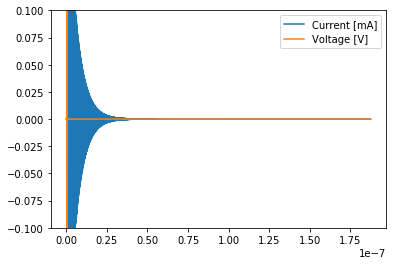

In [7]:
plt.plot(tlist, itime * 1000, label="Current [mA]")
plt.plot(tlist, vtime, label="Voltage [V]")
plt.ylim(-1e-1, 1e-1)
plt.legend()
plt.savefig("Voltage_Current_timeline.png")

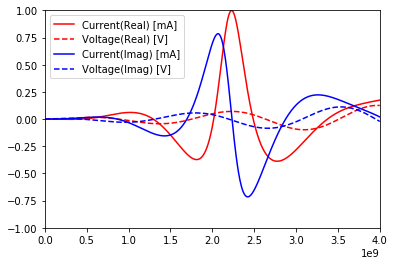

In [8]:
plt.plot(flist, np.real(np.fft.fft(itime)) * 1000, label="Current(Real) [mA]", color="red")
plt.plot(flist, np.real(np.fft.fft(vtime)), label="Voltage(Real) [V]", color="red", linestyle="dashed")
plt.plot(flist, np.imag(np.fft.fft(itime)) * 1000, label="Current(Imag) [mA]", color="blue")
plt.plot(flist, np.imag(np.fft.fft(vtime)), label="Voltage(Imag) [V]", color="blue", linestyle="dashed")
plt.xlim(start, end)
plt.ylim(-1, 1)
plt.legend()